# imports

In [8]:
import numpy as np 
import pandas as pd
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import numpy as np
from mlflow.models.signature import infer_signature
from xgboost import XGBClassifier


In [6]:
import dagshub
dagshub.init(repo_owner='MohammedBilal-0001',repo_name='AIDE506_project',mlflow=True)

Initialized MLflow to track repo "MohammedBilal-0001/AIDE506_project"

Repository MohammedBilal-0001/AIDE506_project initialized!

## Load and  split data

In [9]:
data_file=pd.read_csv('G:\LebanseUni\M2\S1\AIDE506-Advanced Machine learining Topics\Project\Data\processed_data.csv')
data_file.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,-1.277445,0,1,0,0,2,0,0,0,0,0,1,2,-1.160323,-0.994242,0
1,1,0,0,0,0.066327,1,0,0,2,0,2,0,0,0,1,0,3,-0.259629,-0.173244,0
2,1,0,0,0,-1.236724,1,0,0,2,2,0,0,0,0,0,1,3,-0.362660,-0.959674,1
3,1,0,0,0,0.514251,0,1,0,2,0,2,2,0,0,1,0,0,-0.746535,-0.194766,0
4,0,0,0,0,-1.236724,1,0,1,0,0,0,0,0,0,0,1,2,0.197365,-0.940470,1


In [10]:
y=data_file["Churn"]
x=data_file.drop("Churn" , axis=1)
x.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0,0,1,0,-1.277445,0,1,0,0,2,0,0,0,0,0,1,2,-1.160323,-0.994242
1,1,0,0,0,0.066327,1,0,0,2,0,2,0,0,0,1,0,3,-0.259629,-0.173244
2,1,0,0,0,-1.236724,1,0,0,2,2,0,0,0,0,0,1,3,-0.362660,-0.959674
3,1,0,0,0,0.514251,0,1,0,2,0,2,2,0,0,1,0,0,-0.746535,-0.194766
4,0,0,0,0,-1.236724,1,0,1,0,0,0,0,0,0,0,1,2,0.197365,-0.940470


In [11]:
X_train_val, X_test, y_train_val, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
X_train,X_val,y_train,y_val=train_test_split(X_train_val, y_train_val, test_size=0.20, random_state=42)

#### SMOTE

In [12]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print(X_resampled.shape,X_train_val.shape)

(7008, 19) (5986, 19)


# Base Models :
1. Randomforest
2. Logistic Reg
3. XGboost

## find best hyperParameter for each

In [13]:
# Set MLflow experiment name. This will get created if it doesn't exist
experiment_name = "Find_HyperParameter_Experiment_DagsHub"
experiment_id = mlflow.create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='mlflow-artifacts:/b7d6b856a20a424fa6c707997b2db53f', creation_time=1743532788924, experiment_id='0', last_update_time=1743532788924, lifecycle_stage='active', name='Find_HyperParameter_Experiment_DagsHub', tags={}>

In [7]:
experiment_name = "Find_HyperParameter_Experiment"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///g:/LebanseUni/M2/S1/AIDE506-Advanced%20Machine%20learining%20Topics/Project/notebook/mlruns/419857677692309404', creation_time=1742050110773, experiment_id='419857677692309404', last_update_time=1742050110773, lifecycle_stage='active', name='Find_HyperParameter_Experiment', tags={}>

In [14]:
def train_and_log_model(model, X_train, y_train, X_test, y_test,note,is_search,DVC_Hash):
    with mlflow.start_run():
        # Train the model
        model.fit(X_train, y_train)

        if is_search:
            model=model.best_estimator_

        # Make predictions
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        # Compute classification report and confusion matrix
        class_report = classification_report(y_test, y_pred, output_dict=True)
        conf_matrix = confusion_matrix(y_test, y_pred)

        # Log classification metrics
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", class_report["weighted avg"]["precision"])
        mlflow.log_metric("recall", class_report["weighted avg"]["recall"])
        mlflow.log_metric("f1-score", class_report["weighted avg"]["f1-score"])
        
        # Log Data setHash
        mlflow.log_param("DataSetHash",DVC_Hash)
        mlflow.log_param("Seed",42)

        # Log parameters of the model (if applicable)
        if hasattr(model, "get_params"):
            params = model.get_params()
            for param, value in params.items():
                mlflow.log_param(param, value)


        #log 
        class_report_text = classification_report(y_test, y_pred)
        with open("classification_report.txt", "w") as f:
            f.write(class_report_text)
        mlflow.log_artifact("classification_report.txt")
        # Log model
        # Infer signature and create an input example
        input_example = X_train.iloc[:1]  # Use first sample for input example
        signature = infer_signature(X_train, model.predict(X_train))

        # Log model with signature & input example
        mlflow.sklearn.log_model(model, "model", signature=signature, input_example=input_example)

        # Log confusion matrix as an image
        plt.figure(figsize=(6, 4))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")

        mlflow.set_tag("Experiment Notes", note)
        print("classification_report",class_report)
        print(f"Model logged successfully with accuracy={accuracy:.4f}")

In [15]:
type(X_train)

pandas.core.frame.DataFrame

### RF

f:\Users\faiz\anaconda3\envs\AIDE506\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


classification_report {'0': {'precision': 0.8472075869336143, 'recall': 0.8983240223463688, 'f1-score': 0.8720173535791758, 'support': 895.0}, '1': {'precision': 0.6345381526104418, 'recall': 0.5214521452145214, 'f1-score': 0.572463768115942, 'support': 303.0}, 'accuracy': 0.8030050083472454, 'macro avg': {'precision': 0.740872869772028, 'recall': 0.7098880837804451, 'f1-score': 0.7222405608475588, 'support': 1198.0}, 'weighted avg': {'precision': 0.793418906967069, 'recall': 0.8030050083472454, 'f1-score': 0.7962538006615132, 'support': 1198.0}}
Model logged successfully with accuracy=0.8030
🏃 View run lyrical-mouse-389 at: https://dagshub.com/MohammedBilal-0001/AIDE506_project.mlflow/#/experiments/0/runs/bb296b4e76b147fdb1851c4e5e590103
🧪 View experiment at: https://dagshub.com/MohammedBilal-0001/AIDE506_project.mlflow/#/experiments/0


f:\Users\faiz\anaconda3\envs\AIDE506\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


classification_report {'0': {'precision': 0.8857901726427623, 'recall': 0.7452513966480447, 'f1-score': 0.8094660194174758, 'support': 895.0}, '1': {'precision': 0.48764044943820223, 'recall': 0.7161716171617162, 'f1-score': 0.5802139037433155, 'support': 303.0}, 'accuracy': 0.7378964941569283, 'macro avg': {'precision': 0.6867153110404822, 'recall': 0.7307115069048804, 'f1-score': 0.6948399615803956, 'support': 1198.0}, 'weighted avg': {'precision': 0.7850895331344303, 'recall': 0.7378964941569283, 'f1-score': 0.7514832222144119, 'support': 1198.0}}
Model logged successfully with accuracy=0.7379
🏃 View run thoughtful-wren-337 at: https://dagshub.com/MohammedBilal-0001/AIDE506_project.mlflow/#/experiments/0/runs/196681c6cf534931a2c29438b4522853
🧪 View experiment at: https://dagshub.com/MohammedBilal-0001/AIDE506_project.mlflow/#/experiments/0


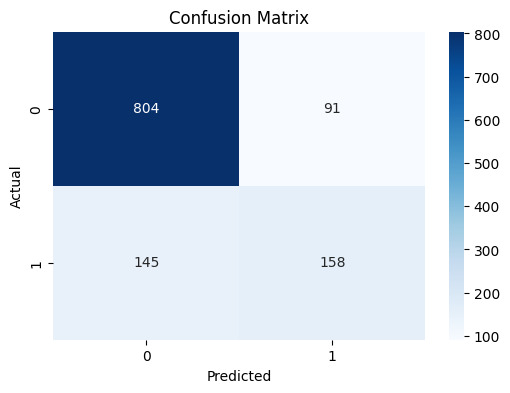

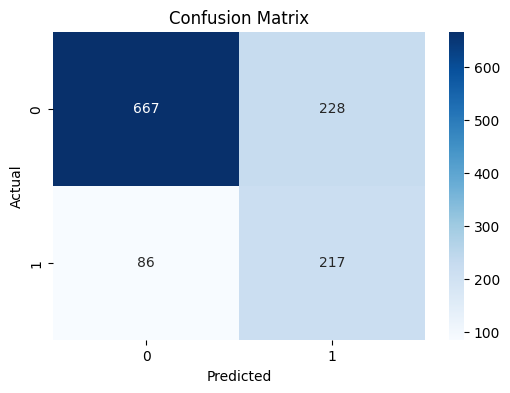

In [22]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [ 'sqrt', 'log2']
}
rf = RandomForestClassifier()
random_search = RandomizedSearchCV(estimator= rf, param_distributions= param_grid, n_iter=100, cv=5, n_jobs=-1, scoring='accuracy')

train_and_log_model(random_search,X_train,y_train,X_val,y_val,"Finding the best hyper parameters for the Randomforest",True,'e79b400eb031a3c4a43701815c361560')
best_parameters=random_search.best_params_
rf_best_params = RandomForestClassifier(**best_parameters)

train_and_log_model(rf_best_params,X_resampled,y_resampled,X_val,y_val,"training  Randomforest on resampled data",False,'e79b400eb031a3c4a43701815c361560')

#### Discus 
Accuracy Decreased from accuracy=0.8119 =>  accuracy=0.7807
but we clearly can see that recall of the positive class increased .51=> .77 
this mean we have less false nigative (client who leaved with out being detected by the model)


...
old 



                precision    recall  f1-score   support

           0       0.84      0.92      0.88      1036
           1       0.70      0.51      0.59       373

    accuracy                           0.81      1409
   macro avg       0.77      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409

new 




                precision    recall  f1-score   support

           0       0.90      0.78      0.84      1036
           1       0.56      0.77      0.65       373

    accuracy                           0.78      1409
   macro avg       0.73      0.78      0.75      1409
weighted avg       0.81      0.78      0.79      140

### Logistic

f:\Users\faiz\anaconda3\envs\AIDE506\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


classification_report {'0': {'precision': 0.8502673796791443, 'recall': 0.888268156424581, 'f1-score': 0.8688524590163934, 'support': 895.0}, '1': {'precision': 0.6197718631178707, 'recall': 0.5379537953795379, 'f1-score': 0.5759717314487632, 'support': 303.0}, 'accuracy': 0.7996661101836394, 'macro avg': {'precision': 0.7350196213985075, 'recall': 0.7131109759020595, 'f1-score': 0.7224120952325783, 'support': 1198.0}, 'weighted avg': {'precision': 0.7919700996139808, 'recall': 0.7996661101836394, 'f1-score': 0.7947766155664837, 'support': 1198.0}}
Model logged successfully with accuracy=0.7997
🏃 View run overjoyed-gnu-942 at: https://dagshub.com/MohammedBilal-0001/AIDE506_project.mlflow/#/experiments/0/runs/a64ce8725e324d5a83cccba821d7a75d
🧪 View experiment at: https://dagshub.com/MohammedBilal-0001/AIDE506_project.mlflow/#/experiments/0


f:\Users\faiz\anaconda3\envs\AIDE506\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


classification_report {'0': {'precision': 0.9031339031339032, 'recall': 0.7083798882681565, 'f1-score': 0.793988728866625, 'support': 895.0}, '1': {'precision': 0.4737903225806452, 'recall': 0.7755775577557755, 'f1-score': 0.5882352941176471, 'support': 303.0}, 'accuracy': 0.7253756260434057, 'macro avg': {'precision': 0.6884621128572742, 'recall': 0.741978723011966, 'f1-score': 0.6911120114921361, 'support': 1198.0}, 'weighted avg': {'precision': 0.7945436653145065, 'recall': 0.7253756260434057, 'f1-score': 0.7419492541346214, 'support': 1198.0}}
Model logged successfully with accuracy=0.7254
🏃 View run bright-grub-14 at: https://dagshub.com/MohammedBilal-0001/AIDE506_project.mlflow/#/experiments/0/runs/faecc27e0197449686ab283804e91f45
🧪 View experiment at: https://dagshub.com/MohammedBilal-0001/AIDE506_project.mlflow/#/experiments/0


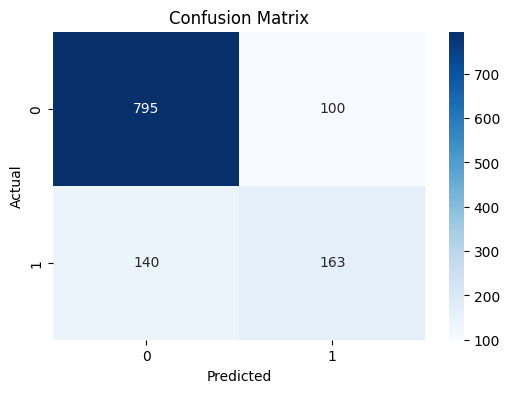

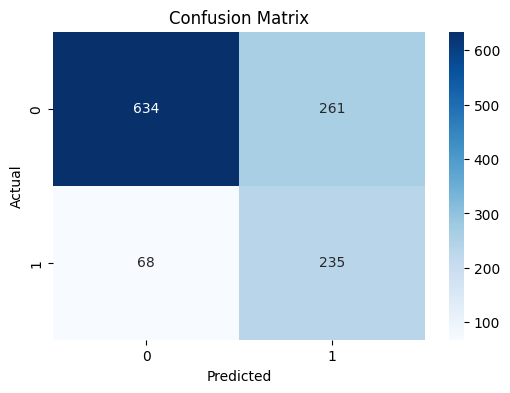

In [24]:

# Define parameter grid
param_grid = [
    {'C': np.logspace(-4, 4, 10), 'penalty': ['l1', 'l2'], 'solver': ['liblinear']},  # liblinear supports only l1, l2
    {'C': np.logspace(-4, 4, 10), 'penalty': ['l1', 'l2', 'elasticnet'], 'solver': ['saga'], 'l1_ratio': [0.1, 0.5, 0.9]}  # saga supports l1, l2, elasticnet
]

# Initialize model
model = LogisticRegression(max_iter=1000)

# GridSearchCV with valid params
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, error_score='raise')


train_and_log_model(grid_search,X_train,y_train,X_val,y_val,"Finding the best hyper parameters for the Logistic Reg",True,'e79b400eb031a3c4a43701815c361560')
best_parameters=grid_search.best_params_
Lr_best_params = LogisticRegression(**best_parameters, max_iter=1000)

train_and_log_model(Lr_best_params,X_resampled,y_resampled,X_val,y_val,"training  Logistic  on resampled data",False,'e79b400eb031a3c4a43701815c361560')


#### Discus
old


                precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
           1       0.68      0.58      0.63       373

    accuracy                           0.82      1409
   macro avg       0.77      0.74      0.75      1409
weighted avg       0.81      0.82      0.81      1409



new 


              precision    recall  f1-score   support

           0       0.92      0.72      0.81      1036
           1       0.52      0.84      0.64       373

    accuracy                           0.75      1409
   macro avg       0.72      0.78      0.73      1409
weighted avg       0.82      0.75      0.77      1409

### XGBoost

Fitting 5 folds for each of 20 candidates, totalling 100 fits


f:\Users\faiz\anaconda3\envs\AIDE506\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:21:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
f:\Users\faiz\anaconda3\envs\AIDE506\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/do

classification_report {'0': {'precision': 0.8509513742071881, 'recall': 0.8994413407821229, 'f1-score': 0.8745247148288974, 'support': 895.0}, '1': {'precision': 0.6428571428571429, 'recall': 0.5346534653465347, 'f1-score': 0.5837837837837838, 'support': 303.0}, 'accuracy': 0.8071786310517529, 'macro avg': {'precision': 0.7469042585321655, 'recall': 0.7170474030643288, 'f1-score': 0.7291542493063405, 'support': 1198.0}, 'weighted avg': {'precision': 0.7983198616036291, 'recall': 0.8071786310517529, 'f1-score': 0.8009900720019614, 'support': 1198.0}}
Model logged successfully with accuracy=0.8072
🏃 View run caring-trout-949 at: https://dagshub.com/MohammedBilal-0001/AIDE506_project.mlflow/#/experiments/0/runs/ccfdbc99ce764a58bfe562a0f80caa81
🧪 View experiment at: https://dagshub.com/MohammedBilal-0001/AIDE506_project.mlflow/#/experiments/0


f:\Users\faiz\anaconda3\envs\AIDE506\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


classification_report {'0': {'precision': 0.8962765957446809, 'recall': 0.753072625698324, 'f1-score': 0.8184578020643595, 'support': 895.0}, '1': {'precision': 0.5044843049327354, 'recall': 0.7425742574257426, 'f1-score': 0.6008010680907877, 'support': 303.0}, 'accuracy': 0.7504173622704507, 'macro avg': {'precision': 0.7003804503387081, 'recall': 0.7478234415620333, 'f1-score': 0.7096294350775736, 'support': 1198.0}, 'weighted avg': {'precision': 0.7971838878014259, 'recall': 0.7504173622704507, 'f1-score': 0.7634077266102758, 'support': 1198.0}}
Model logged successfully with accuracy=0.7504
🏃 View run abrasive-bee-512 at: https://dagshub.com/MohammedBilal-0001/AIDE506_project.mlflow/#/experiments/0/runs/2543a62273324d6ebb9c6a47dda9eaaa
🧪 View experiment at: https://dagshub.com/MohammedBilal-0001/AIDE506_project.mlflow/#/experiments/0


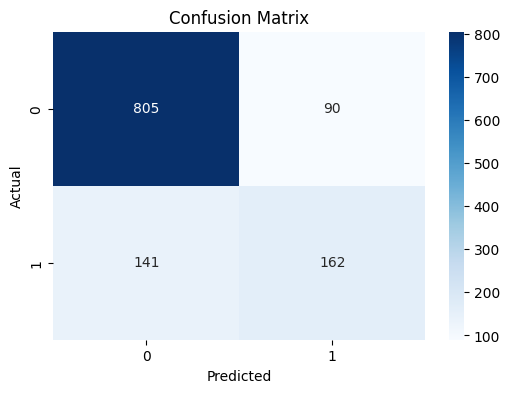

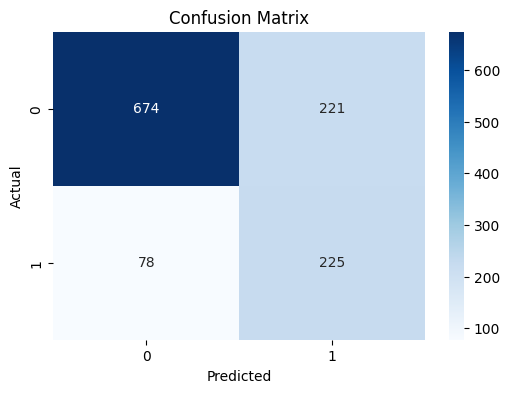

In [26]:

from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define parameter distribution
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of trees
    'max_depth': [3, 5, 7, 9, 12],  # Depth of trees
    'learning_rate': np.logspace(-3, 0, 10),  # Shrinks contribution of trees
    'subsample': [0.6, 0.8, 1.0],  # Percentage of samples used per tree
    'colsample_bytree': [0.6, 0.8, 1.0],  # Percentage of features used per tree
    'gamma': [0, 0.1, 0.3, 0.5, 1],  # Minimum loss reduction for split
    'lambda': np.logspace(-3, 1, 5),  # L2 regularization
    'alpha': np.logspace(-3, 1, 5)  # L1 regularization
}

# Initialize XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

# Randomized Search CV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20,  # Number of different settings to try
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)


train_and_log_model(random_search,X_train,y_train,X_val,y_val,"Finding the best hyper parameters for the XGB ",True,'e79b400eb031a3c4a43701815c361560')
best_parameters=random_search.best_params_
XGB_best_params = XGBClassifier(**best_parameters)

train_and_log_model(XGB_best_params,X_resampled,y_resampled,X_val,y_val,"training  LoXGB on resampled data",False,'e79b400eb031a3c4a43701815c361560')


old

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       895
           1       0.64      0.53      0.58       303

    accuracy                           0.81      1198
   macro avg       0.75      0.72      0.73      1198
weighted avg       0.80      0.81      0.80      1198




new 

              precision    recall  f1-score   support

           0       0.90      0.74      0.82       895
           1       0.50      0.76      0.60       303

    accuracy                           0.75      1198
   macro avg       0.70      0.75      0.71      1198
weighted avg       0.80      0.75      0.76      1198

# Stacked

In [31]:
import mlflow.sklearn

Base_model_RF_url="runs:/ba916d43d31d4729a6d1d4c1c6cf6259/model"
Base_model_Logistic_url="runs:/faecc27e0197449686ab283804e91f45/model"
Base_model_LoXGB_url="runs:/2543a62273324d6ebb9c6a47dda9eaaa/model"

#xgb_meta_model_url= "runs:/7b2d5a2771734a2db0d76810310ee04f/model"



base_model_rf= mlflow.sklearn.load_model(Base_model_RF_url)
base_model_lr= mlflow.sklearn.load_model(Base_model_Logistic_url)
base_model_xgb= mlflow.sklearn.load_model(Base_model_LoXGB_url)

#xgb_meta_model= mlflow.sklearn.load_model(xgb_meta_model_url)




## prepare meta data

In [32]:
import numpy as np
from sklearn.linear_model import LogisticRegression

# Get predicted PROBABILITIES (not hard predictions) from base models
val_probs1 = base_model_rf.predict_proba(X_val)[:, 1]  # Shape: (n_samples,)
val_probs2 = base_model_lr.predict_proba(X_val)[:, 1]
val_probs3 = base_model_xgb.predict_proba(X_val)[:, 1]

test_probs1 = base_model_rf.predict_proba(X_test)[:, 1]
test_probs2 = base_model_lr.predict_proba(X_test)[:, 1]
test_probs3 = base_model_xgb.predict_proba(X_test)[:, 1]

#train_stack = np.column_stack((val_probs1[:, 1], val_probs2[:, 1], val_probs3[:, 1]))
#test_stack = np.column_stack((test_probs1[:, 1], test_probs2[:, 1], test_probs3[:, 1]))


train_stack = pd.DataFrame({
    'RF_proba': val_probs1,
    'LR_proba': val_probs2,
    'XGB_proba': val_probs3
})

test_stack = pd.DataFrame({
    'RF_proba': test_probs1,
    'LR_proba': test_probs2,
    'XGB_proba': test_probs3
})

In [33]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_stack_resampled, y_stack_resampled = smote.fit_resample(train_stack, y_val)

In [34]:
xgb_meta_model = XGBClassifier(
    # Core parameters
    objective='binary:logistic',
    n_estimators=300,
    learning_rate=0.046415888336127774,
    max_depth=9,
    subsample=1.0,
    colsample_bytree=0.8,
    
    # Regularization
    reg_alpha=10.0,  # alpha
    reg_lambda=0.001,  # lambda
    gamma=1,
    
    # Other parameters
    enable_categorical=False,
    missing=np.nan,
    tree_method='hist'  # Added recommended default
)

# Recommended additions (not in original params but often useful):
xgb_meta_model.set_params(
    random_state=42,  # For reproducibility
    eval_metric='logloss'  # For early stopping if needed
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.046415888336127774, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

classification_report {'0': {'precision': 0.9385964912280702, 'recall': 0.6903225806451613, 'f1-score': 0.7955390334572491, 'support': 775.0}, '1': {'precision': 0.5071868583162218, 'recall': 0.875886524822695, 'f1-score': 0.6423927178153446, 'support': 282.0}, 'accuracy': 0.7398297067171239, 'macro avg': {'precision': 0.722891674772146, 'recall': 0.7831045527339282, 'f1-score': 0.7189658756362969, 'support': 1057.0}, 'weighted avg': {'precision': 0.8234995030718344, 'recall': 0.7398297067171239, 'f1-score': 0.7546806975906293, 'support': 1057.0}}
Model logged successfully with accuracy=0.7398
🏃 View run fortunate-elk-777 at: https://dagshub.com/MohammedBilal-0001/AIDE506_project.mlflow/#/experiments/0/runs/c8ea6a9809514a1bb19f9af3452dec60
🧪 View experiment at: https://dagshub.com/MohammedBilal-0001/AIDE506_project.mlflow/#/experiments/0


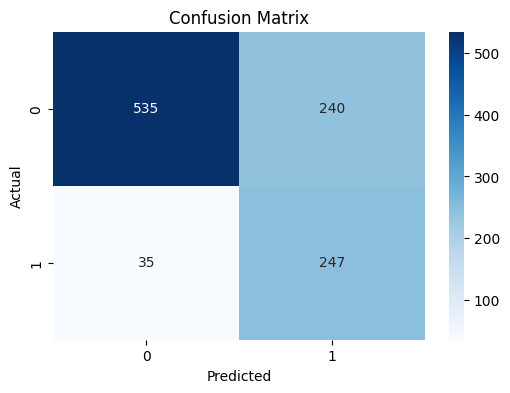

In [37]:
meta_model_proba = LogisticRegression(max_iter=10000)

#meta_model_proba.fit(train_stack, y_val)
#training the final model on the stacked predictions
#meta_model_proba =RandomForestClassifier()
train_and_log_model(xgb_meta_model,X_stack_resampled,y_stack_resampled,test_stack,y_test,"train the meta model(xgb) on Proba meta data resampled",False,'e79b400eb031a3c4a43701815c361560')

# SHAP

## Load models

In [26]:
import shap
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")

# Define the unified model class for classification
class UnifiedClassifier:
    def __init__(self, meta_model, base_models):
        """
        meta_model: pre-trained logistic regression meta model.
        base_models: list of pre-trained base classifiers.
        """
        self.meta_model = meta_model
        self.base_models = base_models

    def get_meta_features(self, X):
        """
        Generate meta features by obtaining probability predictions from each base model.
        Here, we take the probability for the positive class (assumed binary classification).
        If your problem is multiclass, adjust accordingly.
        """
        meta_features = []
        for model in self.base_models:
            # Assuming binary classification; take probability for class 1.
            probs = model.predict_proba(X)[:, 1].reshape(-1, 1)
            meta_features.append(probs)
        meta_features = np.hstack(meta_features)
        return meta_features

    def predict_proba(self, X):
        """
        Predict class probabilities using the meta model based on meta features generated from base models.
        """
        meta_features = self.get_meta_features(X)
        return self.meta_model.predict_proba(meta_features)

    def predict(self, X):
        """
        Predict class labels.
        """
        proba = self.predict_proba(X)
        # Return the class with highest probability.
        return np.argmax(proba, axis=1)

# ------------------------------------------------------


base_models = [base_model_rf, base_model_lr, base_model_xgb]

# Create an instance of the unified classifier
unified_classifier = UnifiedClassifier(xgb_meta_model, base_models)




# ------------------------------------------------------


In [30]:
background = shap.sample(X_train, 100)  # adjust sample size as needed

# When explaining predictions, we use the predict_proba function.
explainer = shap.KernelExplainer(unified_classifier.predict_proba, background)

# Compute SHAP values for the test and training sets.
# Note: SHAP returns explanations per class.
shap_values_test = explainer.shap_values(X_test[:100])


100%|██████████| 100/100 [06:21<00:00,  3.81s/it]


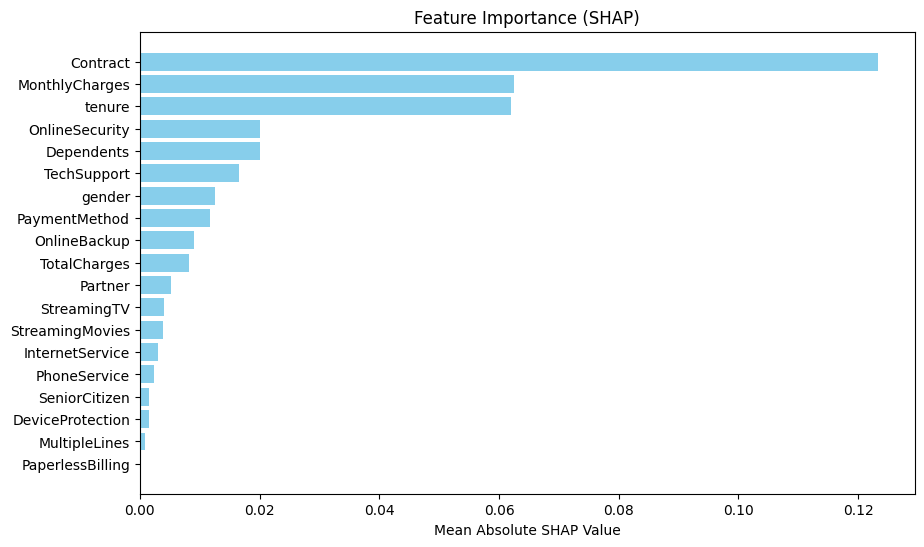

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Compute mean absolute SHAP values per feature
mean_shap_values = np.abs(shap_values_test).mean(axis=(0, 2))  # Averaging over samples and classes

# Sort features by importance
sorted_indices = np.argsort(mean_shap_values)  # Indices of sorted values
sorted_features = X_test.columns[sorted_indices]  # Sorted feature names
sorted_shap_values = mean_shap_values[sorted_indices]  # Sorted SHAP values

# Create sorted bar chart
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_shap_values, color='skyblue')
plt.xlabel("Mean Absolute SHAP Value")
plt.title("Feature Importance (SHAP)")
plt.show()


SHAP feature importance is easy to explain. Features with larger values are important.
As we have seen from the feature importance:
contract
Monthly charges
tenure:How long they are with the company are the important features based on the Catboost model we have selected.


Class: Negative


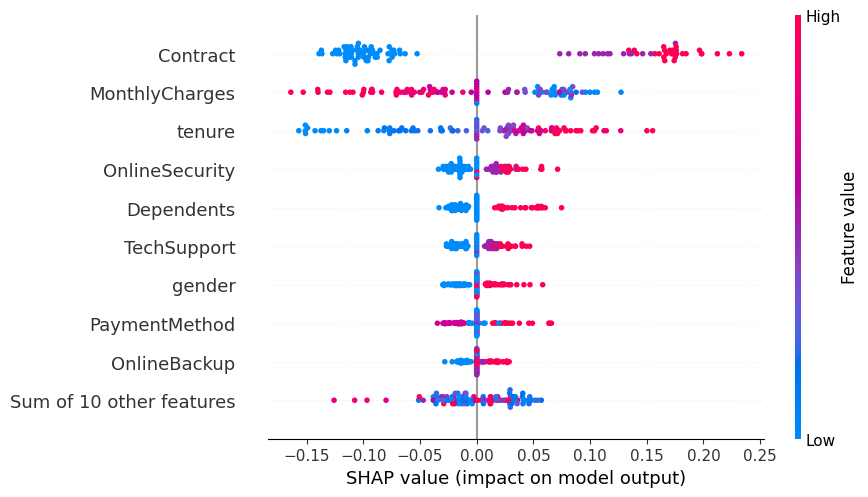


Class: Positive


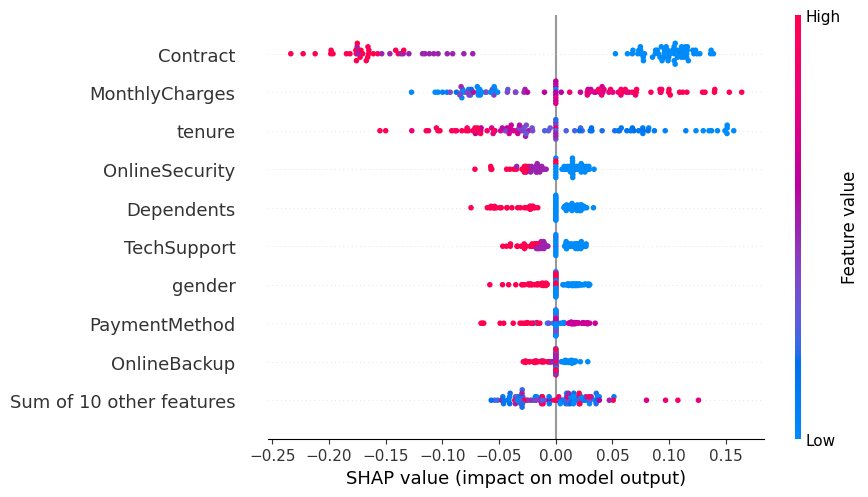

In [32]:
# 2. Plot per-class beeswarm
for class_idx, class_name in enumerate(["Negative", "Positive"]):
    print(f"\nClass: {class_name}")
    shap.plots.beeswarm(shap.Explanation(
        values=shap_values_test[:, :, class_idx],
        base_values=explainer.expected_value[class_idx],
        data=X_test[:100],
        feature_names=X_train.columns,
    ))

- As we have seen in the tenure higher values of the tenure, lower the probability of the customer churn.
- Higher monthly charges increase risk of the customer churn

for the contract type and other categorical features look at the dep plots

In [33]:
print(f"SHAP values shape: {np.array(shap_values_test).shape}")
print(f"X_test shape: {X_test[:100].shape}")

SHAP values shape: (100, 19, 2)
X_test shape: (100, 19)



Class: Negative Force Plot


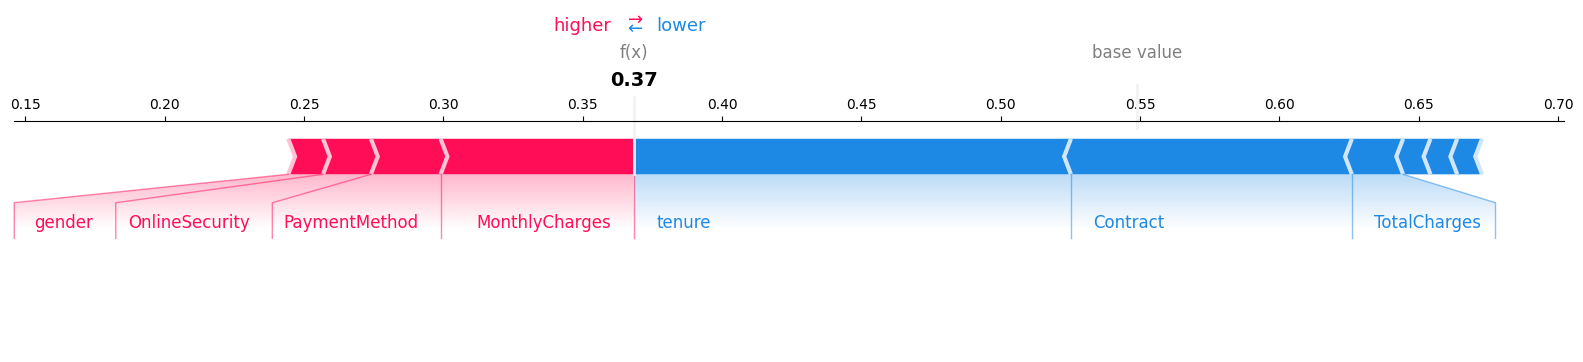


Class: Positive Force Plot


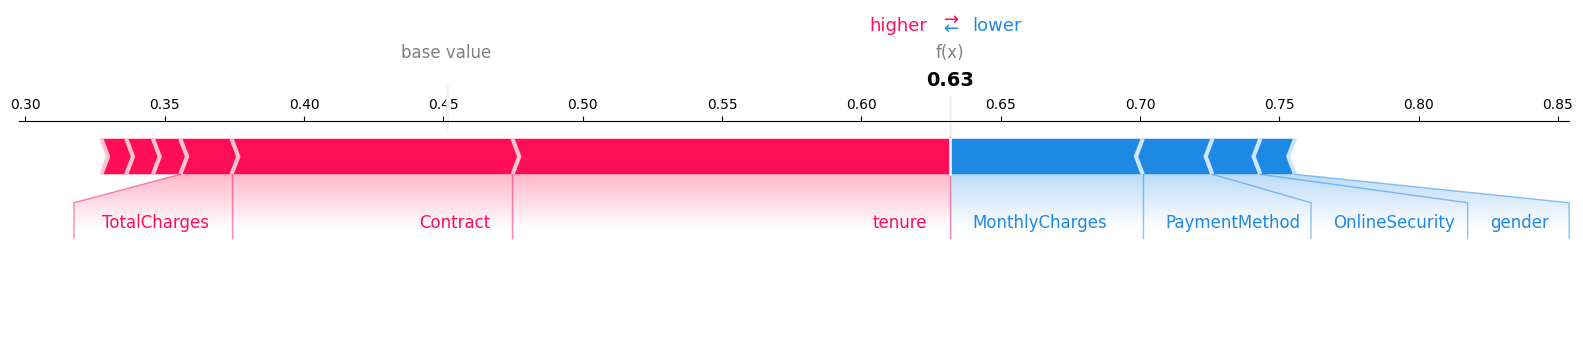

In [35]:
for class_idx, class_name in enumerate(["Negative", "Positive"]):
    print(f"\nClass: {class_name} Force Plot")
    shap.plots.force(
        explainer.expected_value[class_idx],
        shap_values_test[:, :, class_idx][10],  # First sample
        feature_names=X_train.columns,
        matplotlib=True
    )

In [46]:
print(shap_values_test.shape)
print(X_test.shape)

(100, 19, 2)
(1057, 19)


### Contract

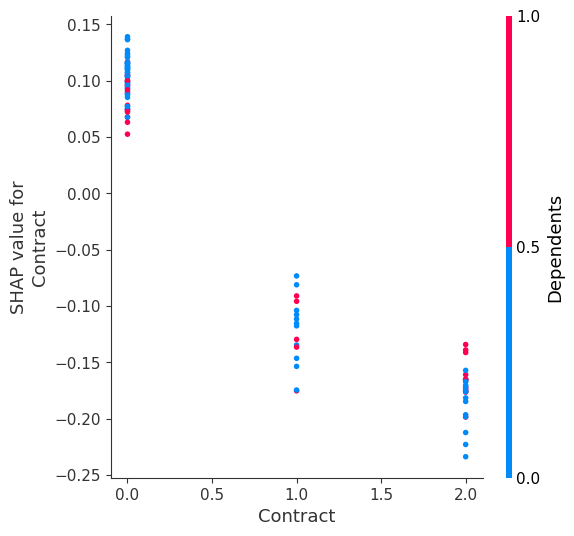

In [42]:
shap_values_2d = shap_values_test[:, :, 1]  # Now shape (100, 19)

fig, ax = plt.subplots(figsize=(6,6), dpi=100)
shap.dependence_plot(
    "Contract",
    shap_values_2d,  # Use 2D version
    X_test.iloc[:100],  # Match sample size
    interaction_index="auto",
    ax=ax
)

- Customers with the Month to month contract most likely to churn
- Customers with the Two year contract most likely to continue with the company

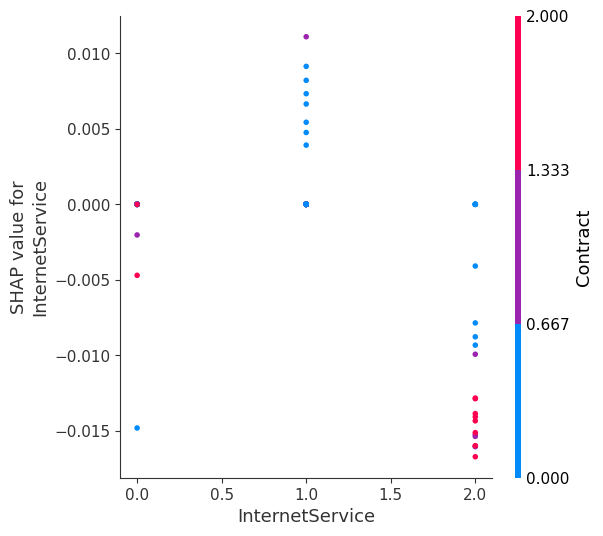

In [43]:
fig, ax = plt.subplots(figsize=(6,6), dpi=100)
shap.dependence_plot(
    "InternetService",
    shap_values_2d, 
    X_test.iloc[:100],  
    interaction_index="auto",
    ax=ax
)

### OnlineSecurity

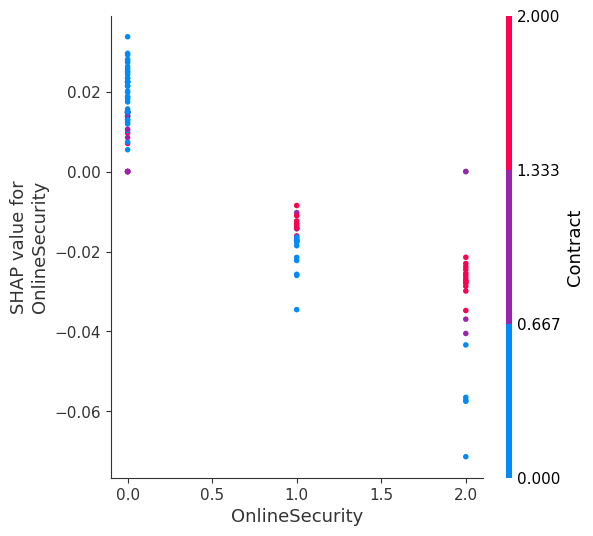

In [49]:
fig, ax = plt.subplots(figsize=(6,6), dpi=100)
shap.dependence_plot(
    "OnlineSecurity",
    shap_values_2d, 
    X_test.iloc[:100], 
    interaction_index="auto",
    ax=ax
)

## monthly chagres

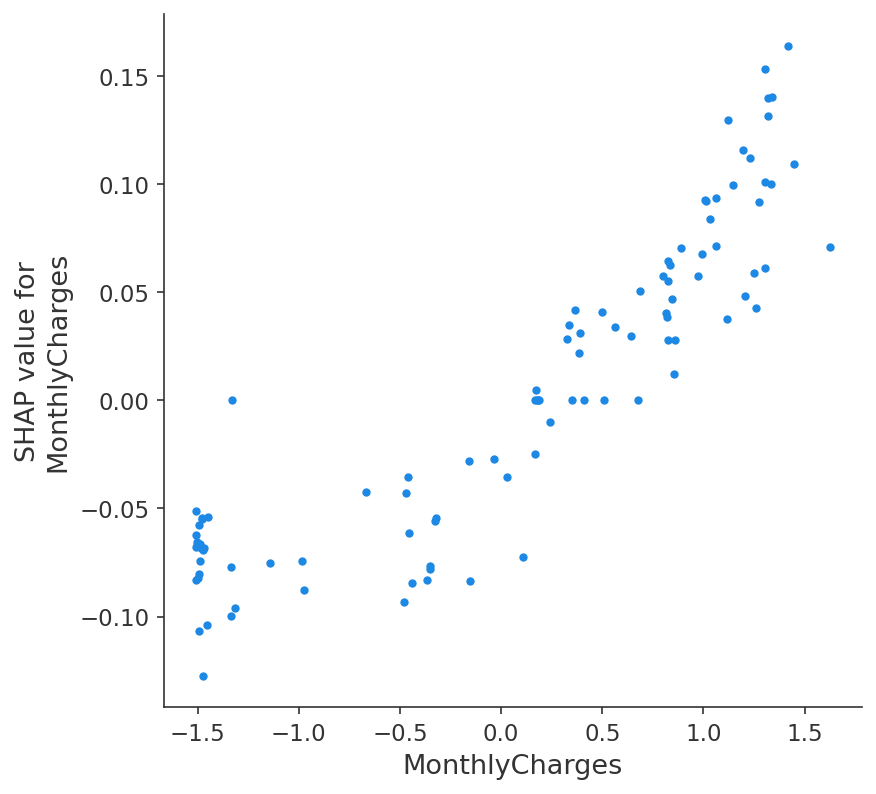

In [47]:
fig, ax1= plt.subplots(figsize=(6,6),dpi=150)

shp_plt = shap.dependence_plot("MonthlyCharges", shap_values_2d,X_test.iloc[:100],ax=ax1, interaction_index=None)

Monthly charges until at around x US Dollars, customer most likely not to churn and continue with the company.
When monthly charges start to increase from y US Dollar and up, customer is most likely to churn
* note this values are standardized x must be around 55$ and y around 100 $

### Tenure

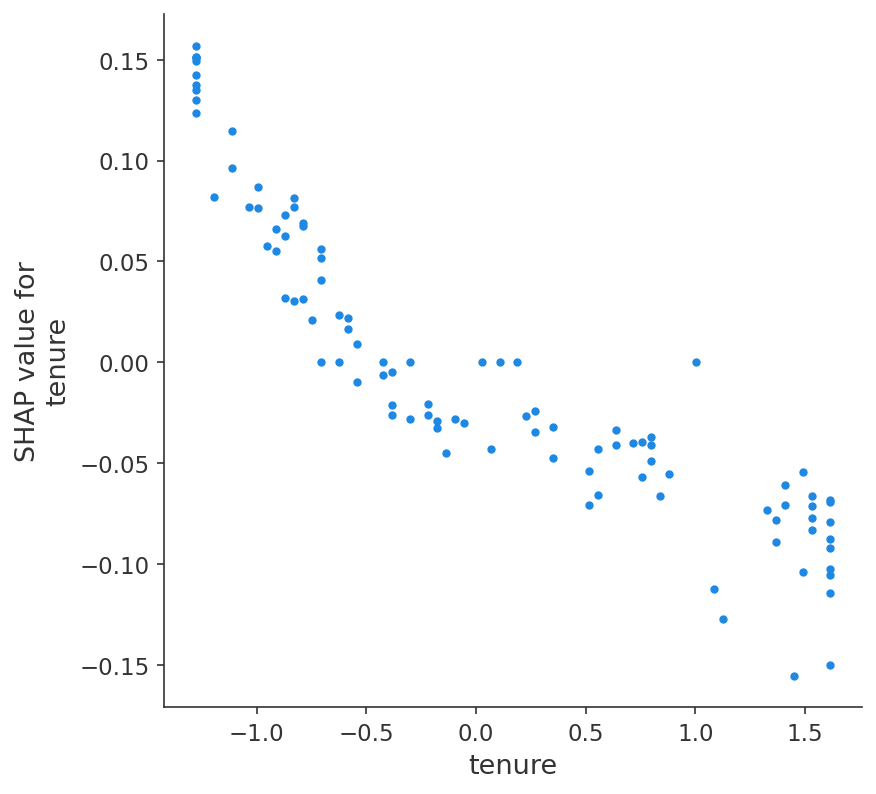

In [48]:
fig, ax1= plt.subplots(figsize=(6,6),dpi=150)

shp_plt = shap.dependence_plot("tenure", shap_values_2d,X_test.iloc[:100],ax=ax1, interaction_index=None)

In [30]:
from sklearn.metrics import classification_report

#preds1 = base_model_rf.predict(X_val)
#preds2 = base_model_lr.predict(X_val)
#preds3 = base_model_xgb.predict(X_val)

#making predictions for the test data
#test_preds1 = base_model_rf.predict(X_test)
#test_preds2 = base_model_lr.predict(X_test)
#test_preds3 = base_model_xgb.predict(X_test)

#train_stack = np.column_stack((preds1,preds2,preds3))
#test_stack = np.column_stack((test_preds1,test_preds2,test_preds3))


y_pred = base_model_rf.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)

# Print a classification report with precision, recall, and F1-score
print("\nClassification Report:")
print(classification_report(y_val, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.76      0.82       895
           1       0.50      0.72      0.59       303

    accuracy                           0.75      1198
   macro avg       0.69      0.74      0.70      1198
weighted avg       0.79      0.75      0.76      1198



# actionable retention strategies based on the most influential factors.

- Contract : Offer long-term contract incentives ("Sign 2-year contract, get 3 months free")
- MonthlyCharges: Targeted discount tiers: "Reduce to $X/month if you stay" for people for 
- Tenure : "Loyalty bonus" at X-month mark
- InternetService : Fiber optic services shows a peak of people who will chrun, try to suggest other services or find the problem with this services (maybe it is expensive)
-OnlineSecurity : No online security are highle chance to chrun

Column: gender
  Female -> 0
  Male -> 1

Column: Partner
  No -> 0
  Yes -> 1

Column: Dependents
  No -> 0
  Yes -> 1

Column: PhoneService
  No -> 0
  Yes -> 1

Column: MultipleLines
  No -> 0
  No phone service -> 1
  Yes -> 2

Column: InternetService
  DSL -> 0
  Fiber optic -> 1
  No -> 2

Column: OnlineSecurity
  No -> 0
  No internet service -> 1
  Yes -> 2

Column: OnlineBackup
  No -> 0
  No internet service -> 1
  Yes -> 2

Column: DeviceProtection
  No -> 0
  No internet service -> 1
  Yes -> 2

Column: TechSupport
  No -> 0
  No internet service -> 1
  Yes -> 2

Column: StreamingTV
  No -> 0
  No internet service -> 1
  Yes -> 2

Column: StreamingMovies
  No -> 0
  No internet service -> 1
  Yes -> 2

Column: Contract
  Month-to-month -> 0
  One year -> 1
  Two year -> 2

Column: PaperlessBilling
  No -> 0
  Yes -> 1

Column: PaymentMethod
  Bank transfer (automatic) -> 0
  Credit card (automatic) -> 1
  Electronic check -> 2
  Mailed check -> 3

Column: Churn
  No -> 0
  Yes -> 1

# dags hub

In [3]:
!pip install dagshub

  Using cached dagshub-0.5.9-py3-none-any.whl.metadata (12 kB)
  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached dacite-1.6.0-py3-none-any.whl.metadata (14 kB)
  Using cached tenacity-9.0.0-py3-none-any.whl.metadata (1.2 kB)
  Using cached gql-3.5.2-py2.py3-none-any.whl.metadata (9.4 kB)
  Using cached dataclasses_json-0.6.7-py3-none-any.whl.metadata (25 kB)
  Using cached treelib-1.7.1-py3-none-any.whl.metadata (1.4 kB)
  Using cached pathvalidate-3.2.3-py3-none-any.whl.metadata (12 kB)
  Using cached boto3-1.37.24-py3-none-any.whl.metadata (6.7 kB)
  Using cached dagshub_annotation_converter-0.1.8-py3-none-any.whl.metadata (2.5 kB)
  Using cached httpcore-1.0.7-py3-none-any.whl.metadata (21 kB)
  Using cached h11-0.14.0-py3-none-any.whl.metadata (8.2 kB)
  Using cached botocore-1.37.24-py3-none-any.whl.metadata (5.7 kB)
  Using cached s3transfer-0.11.4-py3-none-any.whl.metadata (1.7 kB)
  Using cached marshmallow-3.26.1-py3-none-any.whl.metadata (7.3 kB)
 